In [70]:
%matplotlib inline
import numpy as np
from numpy.random import multinomial
from matplotlib import pyplot as plt
from scipy import stats

## Part 1: Gibbs Sampling from Exam Scores

In [2]:
def gibbs(y, mu0=80., sigma0=16., alpha=3., beta=50., n_samples=1000):
    
    N = y.shape[0]
    mu = 50
    sigma=4
    samples = np.zeros((n_samples,2))
    
    def next_sample(mu_, sigma_):
        #resample mu
        sigma_s = (1./sigma0 + N/sigma_)**(-1)
        mu_s = sigma_s*((mu0/sigma0) + np.sum(y)/sigma_)
        mu_out = np.random.normal(mu_s, scale=np.sqrt(sigma_s))
        
        #resample sigma squared
        alpha_s = alpha + N/2.
        beta_s = beta + 0.5*np.sum((y-mu_out)**2)
        sigma_out = stats.invgamma.rvs(alpha_s, scale=beta_s)
        return mu_out, sigma_out
    
    for i in xrange(n_samples):
        mu, sigma = next_sample(mu,sigma)
        samples[i,:] = [mu, sigma]
    return samples

In [3]:
filename = 'examscores.csv'
data = np.genfromtxt(filename)

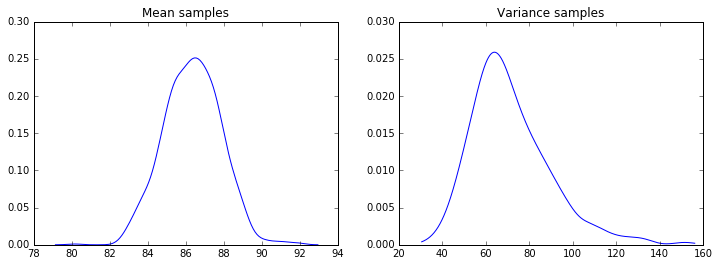

In [7]:
samples = gibbs(data,n_samples=1000)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
mu_kernel = stats.gaussian_kde(samples[:,0])
x_min = min(samples[:,0])-1
x_max = max(samples[:,0]) + 1
x_mu = np.arange(x_min, x_max, 0.1)
plt.plot(x_mu,mu_kernel(x_mu))
plt.title('Mean samples')

plt.subplot(1,2,2)
sigma_kernel = stats.gaussian_kde(samples[:,1])
x_min = min(samples[:,1])-1
x_max = max(samples[:,1]) + 1
x_sigma = np.arange(x_min, x_max, 0.1)
plt.plot(x_sigma,sigma_kernel(x_sigma))
plt.title('Variance samples')
plt.show()

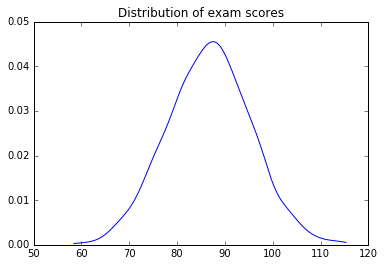

In [316]:
grade_samples = []
for s in samples:
    grade_samples.append(np.random.normal(s[0],s[1]**0.5))
    
plt.figure(figsize=(6,4))

mu_kernel = stats.gaussian_kde(grade_samples)
x_min = min(grade_samples)-1
x_max = max(grade_samples) + 1
x_mu = np.arange(x_min, x_max, 0.1)
plt.plot(x_mu,mu_kernel(x_mu))
plt.title('Distribution of exam scores')
plt.show()

## Part 2: LDA

Below we complete a class to perform LDA inference.

In [328]:
import numpy as np
from scipy.special import gammaln
import string

def loadStopwords(filename):
    """ This function is given. """
    infile = open(filename,'r')
    stopwords = infile.readlines()
    for i in xrange(len(stopwords)):
        stopwords[i] = stopwords[i].rstrip()
    stopwords.append('')
    return stopwords

class LDACGS(object):

    def __init__(self, n_topics, alpha = 0.1, beta = 0.1):
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self,filename,stopwords=None):
        infile = open(filename,'r')
        #doclines = paragraphs (in the Reagan addresses)
        self.originals = [line.rstrip() for line in infile]
        doclines = [line.translate(string.maketrans("",""),string.punctuation).lower().split(' ') for line in self.originals]   
        n_docs = len(doclines)
        self.vocab = []
        for i in xrange(n_docs):
            self.vocab += doclines[i]
        self.vocab = list(set(self.vocab))
        if stopwords != None:
            self.vocab = np.sort(self._removeStopwords(stopwords)).tolist()
        self.documents = []
        for i in xrange(n_docs):
            self.documents.append({})
            for j in xrange(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])
        
                    
    def initialize(self):
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)

        # initialize the three count matrices
        # the (i,j) entry of self.nmz is # of words in document i assigned to topic j
        self.nmz = np.zeros((self.n_docs,self.n_topics))
        # the (i,j) entry of self.nzw is # of times term j is assigned to topic i
        self.nzw = np.zeros((self.n_topics,self.n_words))
        # the (i)-th entry is the number of times topic i is assigned in the corpus
        self.nz = np.zeros(self.n_topics)

        # initialize the topic assignment dictionary
        self.topics = {} # key-value pairs of form (m,i):z
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                w = self.documents[m][i]
                z = np.random.randint(0,self.n_topics)
                self.nmz[m,z] += 1
                self.nzw[z,w] += 1
                self.nz[z] += 1
                self.topics[(m,i)] = z

    def sample(self,filename, burnin=100, sample_rate=5, n_samples=10, stopwords=None):
        self.buildCorpus(filename,stopwords)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics,self.n_words))
        self.total_nmz = np.zeros((self.n_docs,self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        print "Burning in"
        for i in xrange(burnin):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i] = self._loglikelihood()
        print "Sampling"
        for i in xrange(n_samples*sample_rate):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i+burnin] = self._loglikelihood()
            if not i%sample_rate:
                # accumulate counts
                self.total_nzw += self.nzw
                self.total_nmz += self.nmz

    def phi(self):
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        for k in xrange(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in xrange(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        lines = np.zeros((self.n_topics,n_lines))
        for i in xrange(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self,stopwords):
        output = []
        for x in self.vocab:
            if x not in stopwords:
                output.append(x)
        return output

    def _conditional(self, m, w):
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist/sum(dist)

    def _sweep(self):
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                w = self.documents[m][i]
                z = self.topics[(m,i)]
                self.nmz[m,z] -= 1
                self.nzw[z,w] -= 1
                self.nz[z] -= 1
                dist = self._conditional(m,w)
                new_z = np.argmax(multinomial(1, pvals = dist))
                self.nmz[m,new_z] += 1
                self.nzw[new_z,w] += 1
                self.nz[new_z] += 1
                self.topics[(m,i)] = new_z

    def _loglikelihood(self):
        lik = 0

        for z in xrange(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in xrange(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik
    
    def show_results(self, n_terms=10):
        self.phi()
        self.theta()
        topic_terms = self.topterms(n_terms)
        for i, terms in enumerate(topic_terms):
            print "\nTopic #%d:"%(i+1)
            print ', '.join(terms)

### Results of LDA inference on the Reagan dataset

We create an LDA object with 20 topics. Burn-in time is 200 iterations. We remove the common words listed below, such as 'a' and 'the', from the vocabulary so that these words will not be classified into any topic. After burning in, we take 15 samples.

It appears that the log probability never completely leveled off, but the rate of improvement slowed down significantly after about 100 iterations. Below the plot, the most important words for each of the 20 topics are listed.

In [330]:
lda = LDACGS(n_topics=20)
common_words = ['the', 'a', 'an', 'of', 'to', 'is', 'are', 'and', 'in', 'for', 'that', '']
n_burn = 200
lda.sample('reagan.txt',burnin=n_burn,n_samples=15, stopwords=common_words)

Burning in
Sampling


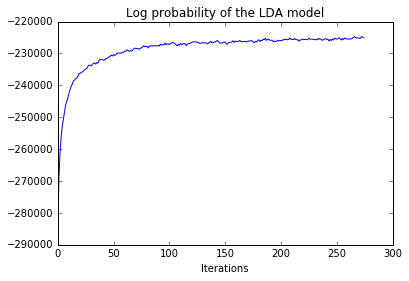

In [346]:
plt.plot(np.arange(lda.logprobs.size), lda.logprobs)
plt.title('Log probability of the LDA model')
plt.xlabel('Iterations')
plt.show()

In [343]:
lda.show_results(12)


Topic #1:
welfare, social, programs, poverty, security, system, dependency, how, many, elderly, support, illness

Topic #2:
power, me, failed, confidence, hungry, million, youll, farmers, never, governments, used, war

Topic #3:
our, we, world, with, peace, trade, on, will, as, must, be, free

Topic #4:
you, god, bless, thank, your, three, then, america, music, much, pounds, days

Topic #5:
we, our, this, us, but, not, america, will, have, as, it, be

Topic #6:
freedom, democratic, democracy, nicaragua, people, support, central, cause, afghanistan, fighters, their, peace

Topic #7:
education, schools, families, school, need, children, excellence, give, parents, use, child, basics

Topic #8:
amendment, within, states, constitutional, countries, live, congress, ive, why, pass, constitution, constitutions

Topic #9:
we, it, i, our, will, have, as, but, be, not, must, now

Topic #10:
who, crime, victims, life, unborn, child, without, abortion, human, woman, lebanon, tragedy

Topic #11:
he

We can assign a label by hand to each one of the topics.
1. Welfare and social programs
2. Farmers?
3. World peace and free trade
4. God bless America.
5. More America
6. Supporting democracy
7. Education
8. The Constitution and Congress
9. Common words
10. Crime and abortion
11. Heroism?
12. State of the Union addresses
13. Space, the final frontier of technology
14. Nuclear race against the Soviets
15. Tax reform
16. Jobs and markets
17. Honor?
18. Addressing Congress
19. Federal government spending
20. The economy, industry, and inflation
